In [45]:
from impedance import preprocessing
import pandas as pd
import os


data_path = os.path.join("wyniki", "1.txt")

data = pd.read_csv(data_path, sep="\t", header=None)


frequencies, Z = data.iloc[:,0,], data.iloc[:,1] - 1j*data.iloc[:,2]
# frequencies, Z = data.iloc[:,0], data.iloc[:,1] + 1j*data.iloc[:,2]

# keep only the impedance data in the first quandrant
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)

In [46]:
frequencies

0     4501.43950
1     3064.02150
2     2085.67090
3     1419.54420
4      965.93054
5      657.68512
6      447.56531
7      304.70715
8      207.45621
9      141.21979
10      96.13857
11      65.43979
12      44.52974
13      30.32021
14      20.64072
15      14.04285
16       9.56245
17       6.51041
18       4.42886
19       3.01408
20       2.05214
21       1.39759
22       0.95072
23       0.64737
24       0.44079
25       0.29994
Name: 0, dtype: float64

In [54]:
from impedance.models.circuits import CustomCircuit

circuit = 'R0-p(C1,R1)-p(C2,R2)'
initial_guess = [100, .01, 100, .01, 900]

circuit_model = CustomCircuit(circuit, initial_guess=initial_guess)

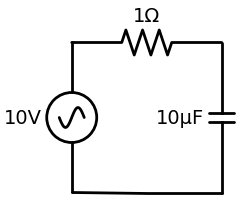

In [ ]:
import schemdraw
import schemdraw.elements as elm
with schemdraw.Drawing() as d:
    d += elm.Resistor().right().label('1ohm')
    d += elm.Capacitor().down().label('10μF')
    d += elm.Line().left()
    d += elm.SourceSin().up().label('10V')

    # d.save('simple_circuit.svg')

Drawing a simple R-C circuit...


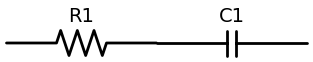


Drawing a complex nested circuit: R-p(C,L-p(R,C))...


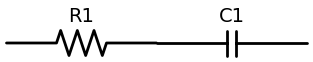

AttributeError: 'Drawing' has no attribute move_to

In [69]:
import schemdraw
import schemdraw.elements as elm
import re

def draw_circuit(circuit_string: str, **kwargs):
    """
    Draws a circuit schematic from an impedance.py model string.

    This function parses a string defining a circuit model (e.g., 'R-p(C,R-W)')
    and uses the schemdraw library to generate a visual representation.

    Args:
        circuit_string (str): The circuit model string.
            - Use '-' for series connections (e.g., 'R-C').
            - Use 'p(A,B,...)' for parallel connections (e.g., 'p(R,C)').
            - Elements are identified by their first letter (R, C, L, W, etc.).
        **kwargs: Additional keyword arguments to pass to the schemdraw.Drawing() constructor
                  (e.g., file='circuit.svg', show=False).

    Returns:
        schemdraw.Drawing: The generated schemdraw Drawing object.
    """
    
    # --- Helper function to split strings while respecting parentheses ---
    def split_at_toplevel(s: str, delimiter: str) -> list[str]:
        """Splits a string by a delimiter, ignoring delimiters inside parentheses."""
        parts = []
        balance = 0
        start_index = 0
        for i, char in enumerate(s):
            if char == '(':
                balance += 1
            elif char == ')':
                balance -= 1
            elif char == delimiter and balance == 0:
                parts.append(s[start_index:i])
                start_index = i + 1
        parts.append(s[start_index:])
        return parts

    # --- Mapping of circuit element prefixes to schemdraw elements ---
    ELEMENT_MAP = {
        'R': elm.Resistor,
        'C': elm.Capacitor,
        'L': elm.Inductor,
        # 'W': elm.Warburg,       # Standard Warburg element
        # 'Ws': elm.WarburgShort, # Warburg element with short-circuit terminus
        # 'Wo': elm.WarburgOpen,  # Warburg element with open-circuit terminus
        'E': elm.Element,       # Generic element box (for CPE, etc.)
        'G': elm.Element,       # Generic element for Gerischer
    }

    # --- Recursive drawing function ---
    def _draw_recursive(d: schemdraw.Drawing, circuit_part: str):
        """Recursively draws a part of the circuit string."""
        
        # First, split the part into series components
        series_parts = split_at_toplevel(circuit_part, '-')

        for part in series_parts:
            # Check if the component is a parallel block
            if part.lower().startswith('p(') and part.endswith(')'):
                # Extract content inside p(...)
                content = part[2:-1]
                parallel_parts = split_at_toplevel(content, ',')
                
                # Store the start and end points of the parallel block
                start_node = d.here
                
                # Draw the first branch of the parallel circuit
                _draw_recursive(d, parallel_parts[0])
                
                end_node = d.here

                # Draw the remaining branches
                for p_part in parallel_parts[1:]:
                    d.push()  # Save the current drawing position
                    d.move_to(start_node) # Go back to the start of the parallel block
                    _draw_recursive(d, p_part)
                    d.move_to(end_node) # Explicitly connect to the end node
                    d.pop()   # Return to the drawing position after the parallel block
            
            else:
                # It's a single element
                # Use regex to find the first letter (element type)
                match = re.match(r"([a-zA-Z]+)", part)
                if match:
                    element_type_key = match.group(1)[0].upper()
                    
                    # Get the corresponding schemdraw class or use a generic box
                    ElementClass = ELEMENT_MAP.get(element_type_key, elm.Element)
                    
                    # Add the element to the drawing with its full name as the label
                    d += ElementClass().label(part)

    # --- Main function logic ---
    # Create a new drawing
    with schemdraw.Drawing(**kwargs) as d:
        # Start the recursive drawing process with the full circuit string
        _draw_recursive(d, circuit_string)
    
    return d

# --- Example Usage ---
if __name__ == '__main__':
    # Example 1: A simple Resistor-Capacitor circuit in series
    print("Drawing a simple R-C circuit...")
    rc_circuit = draw_circuit('R1-C1')
    rc_circuit.draw() # This will open a viewer window

    # Example 2: Randles circuit
    # A resistor in series with a parallel combination of a capacitor and another resistor/Warburg element.
    # print("\nDrawing a Randles circuit: R-p(C,R-W)...")
    # randles_circuit = draw_circuit('Rs-p(Cdl,Rct-Ws)')
    # randles_circuit.draw()
    # You can also save the output directly to a file
    # randles_circuit.save('randles_circuit.svg') 

    # Example 3: A more complex nested circuit
    print("\nDrawing a complex nested circuit: R-p(C,L-p(R,C))...")
    complex_circuit = draw_circuit('R1-p(C1,L1-p(R2,C2))')
    complex_circuit.draw()


In [64]:
circuit_model.plot()

/home/kuba/Coding/cholerny-impedant/.venv/lib64/python3.13/site-packages/impedance/visualization.py:171: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Z_df = pd.concat([Z_df, df], ignore_index=True)


alt.HConcatChart(...)

In [55]:
circuit_model.fit(frequencies, Z)

In [56]:
circuit_model.parameters_

array([1.23751345e+02, 3.08902920e-06, 1.07158359e+04, 9.53826389e-07,
       4.19062437e+02])

In [57]:
Z_fit = circuit_model.predict(frequencies)

In [58]:
Z_fit

array([  127.01695344  -48.22604382j,   130.73704511  -70.36861463j,
         138.54445899 -101.89252127j,   154.43993282 -145.26569196j,
         184.88270673 -200.99339074j,   236.72447152 -263.99332834j,
         310.12857507 -323.21109362j,   390.70693825 -371.2968274j ,
         459.09525961 -419.94448834j,   508.39707131 -496.43918977j,
         546.46479757 -630.19200608j,   589.32934857 -850.16303769j,
         661.12844687-1189.99194684j,   803.25497596-1689.32763568j,
        1093.22433028-2389.35510534j,  1666.68485267-3298.74354986j,
        2705.01334222-4310.78064504j,  4324.58617001-5127.72924291j,
        6339.87992953-5344.54714008j,  8235.55697969-4825.59501108j,
        9607.37250881-3871.01178395j, 10423.78160902-2873.62297118j,
       10855.43806772-2040.15382063j, 11067.84585764-1417.79268784j,
       11169.33698573 -974.67010334j, 11217.10966204 -666.20425833j])

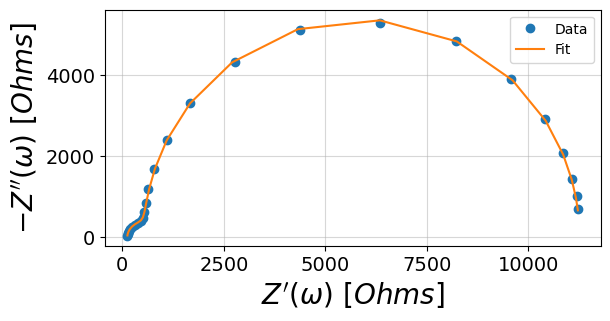

In [59]:
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist

fig, ax = plt.subplots()
plot_nyquist(Z, fmt='o', scale=1, ax=ax)
plot_nyquist(Z_fit, fmt='-', scale=1, ax=ax)

plt.legend(['Data', 'Fit'])
plt.show()